In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as mpl
from matplotlib import pyplot as plt

from scipy.stats import zscore, pearsonr, spearmanr

from collections import defaultdict, Counter

from matplotlib import cm
from adjustText import adjust_text

from tqdm.auto import tqdm
tqdm.pandas()

/Users/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/tqdm/_tqdm.py:603: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Summary

This notebook describes how to reproduce the analysis in Figure 5 regarding the SHP2 protein. In particular, here we reproduce the analysis that led to discovery of phosphorylated SHP2 as the primary determinant of SHP2 sensitivity, as opposed to raw PTPN11 (the gene that encodes SHP2) expression.

# Load annotations

In [2]:
rppa = pd.read_hdf("../data/CCLE_RPPA_20181003.hdf", key="rppa")
ccle_genex = pd.read_hdf(
    "../data/CCLE_RNAseq_rsem_genes_tpm_20180929.hdf", key="ccle_genex")

avana = pd.read_hdf("../data/Achilles_gene_effect.hdf", key="avana")
drive = pd.read_hdf("../data/D2_DRIVE_gene_dep_scores.hdf", key="drive")
achilles = pd.read_hdf(
    "../data/D2_Achilles_gene_dep_scores.hdf", key="achilles")

rppa_info = pd.read_excel(
    "../data/41586_2019_1186_MOESM17_ESM.xlsx", sheet_name="RPPA_Ab_information")

The RPPA info document provides antibody to gene mappings for matching RPPA antibody IDs to gene IDs used in the dependency screens and gene expression data. Here we add these mapped gene names to the RPPA info DataFrame.

In [3]:
avana_name_map = dict(zip(["_".join(x.split("_")[:-1])
                           for x in avana.columns], avana.columns))
drive_name_map = dict(zip(["_".join(x.split("_")[:-1])
                           for x in drive.columns], drive.columns))
achilles_name_map = dict(zip(["_".join(x.split("_")[:-1])
                              for x in achilles.columns], achilles.columns))
gene_name_map = dict(zip(["_".join(x.split("_")[:-1])
                          for x in ccle_genex.columns], ccle_genex.columns))

rppa_info["avana_gene"] = rppa_info["Target_Genes"].apply(
    lambda x: avana_name_map.get(x, ""))
rppa_info["drive_gene"] = rppa_info["Target_Genes"].apply(
    lambda x: drive_name_map.get(x, ""))
rppa_info["achilles_gene"] = rppa_info["Target_Genes"].apply(
    lambda x: achilles_name_map.get(x, ""))
rppa_info["gene"] = rppa_info["Target_Genes"].apply(
    lambda x: gene_name_map.get(x, ""))

We discovered pSHP2 as an interesting gene by looking for genes in which the relative abundances of the RPPA antibody targeting the encoded protein were a better predictor of the same gene's dependency than RNA expression values. 

For computing these correlations between protein levels, gene expression, and dependency scores we first define a helper function for getting the raw correlation values.

In [4]:
def correlate_nan(x, y, method="pearson"):

    assert method == "pearson" or method == "spearman", "Correlation method must be Pearson or Spearman!"

    x = x.dropna()
    y = y.dropna()
    x, y = x.align(y, join="inner")

    if len(x >= 25) and len(y >= 25):
        if method == "pearson":
            return pearsonr(x, y)
        elif method == "spearman":
            return spearmanr(x, y)

    else:

        return (0, 1)

We also define a helper function to get the correlation value per each row of the DataFrame, or for each antibody.

In [5]:
def dependency_correlates(row):

    ab = row["Antibody_Name"]
    avana_gene = row["avana_gene"]
    drive_gene = row["drive_gene"]
    achilles_gene = row["achilles_gene"]
    gene = row["gene"]

    if avana_gene != "":
        row["avana_protein_corr"] = correlate_nan(
            rppa[ab], avana[avana_gene])[0]
    if drive_gene != "":
        row["drive_protein_corr"] = correlate_nan(
            rppa[ab], drive[drive_gene])[0]
    if achilles_gene != "":
        row["achilles_protein_corr"] = correlate_nan(
            rppa[ab], achilles[achilles_gene])[0]

    if gene != "":
        if avana_gene != "":
            row["avana_mrna_corr"] = correlate_nan(
                ccle_genex[gene], avana[avana_gene])[0]
        if drive_gene != "":
            row["drive_mrna_corr"] = correlate_nan(
                ccle_genex[gene], drive[drive_gene])[0]
        if achilles_gene != "":
            row["achilles_mrna_corr"] = correlate_nan(
                ccle_genex[gene], achilles[achilles_gene])[0]

    return row

In [6]:
rppa_info = rppa_info.progress_apply(dependency_correlates, axis=1)

To visualize the relationships between gene-based and protein-based predictability of dependencies, we can plot on the x-axis the association between the protein levels and the dependency, and on the y-axis the association between the gene expression levels and the same dependency. Most genes will fall on the diagonal as their protein levels are closely tied to their gene expression levels and vice-versa, but a few will show that the protein expression level is a better determinant of dependency.

In [7]:
def plot_rna_protein(protein_corrs, rna_corrs, ax):

    x = protein_corrs
    y = rna_corrs
    labels = np.array(rppa_info["Antibody_Name"])
    labels_mask = ((x-y) < -0.25) & (x < -0.1)

    plt.axvline(x=0, linestyle="--", color="black", alpha=0.5)
    plt.axhline(y=0, linestyle="--", color="black", alpha=0.5)

    ax.scatter(x,
               y,
               linewidth=1,
               edgecolor="black"
               )

    texts = []

    for x_pos, y_pos, label in zip(x[labels_mask],
                                   y[labels_mask],
                                   labels[labels_mask]):

        plt.scatter(x_pos, y_pos, c="red", s=16)

        texts.append(plt.text(x_pos, y_pos, label.replace("_Caution", ""),
                              ha='center', va='center'))

    adjust_text(texts, ha="right")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    xy_min = min(plt.xlim()[0], plt.ylim()[0])
    xy_max = max(plt.xlim()[1], plt.ylim()[1])

    plt.xlim(xy_min, xy_max)
    plt.ylim(xy_min, xy_max)

    plt.xlabel("Protein expression vs. dependency")
    plt.ylabel("RNA expression vs. dependency")

Here we see on the Achilles screening plot that the particular SHP2 variant with phosphorylation of tyrosine at position 542 (SHP-2_pY542) is closely associated with knockdown sensitivity to PTPN11. We also see that MDM4/MDMX shows up as well, in line with what we would expect from Figure 4.

In [ ]:
plt.figure(figsize=(15, 4))

plot_rna_protein(rppa_info["avana_protein_corr"],
                 rppa_info["avana_mrna_corr"],
                 plt.subplot(131))
plt.title("Avana")

plot_rna_protein(rppa_info["drive_protein_corr"],
                 rppa_info["drive_mrna_corr"],
                 plt.subplot(132))
plt.title("DRIVE")

plot_rna_protein(rppa_info["achilles_protein_corr"],
                 rppa_info["achilles_mrna_corr"],
                 plt.subplot(133))
plt.title("Achilles")

plt.subplots_adjust(wspace=0.25)

plt.savefig("../plots/figure5-a.pdf", bbox_inches="tight")

If we plot the raw protein and mRNA levels for SHP2/PTPN11, we see a distinct association with cell lines with high levels of pSHP2 protein are highly sensitive to PTPN11 knockdown. On the other hand, we see no discernable relationship between PTPN11 mRNA expression levels and sensitivty to PTPN11 inactivation.

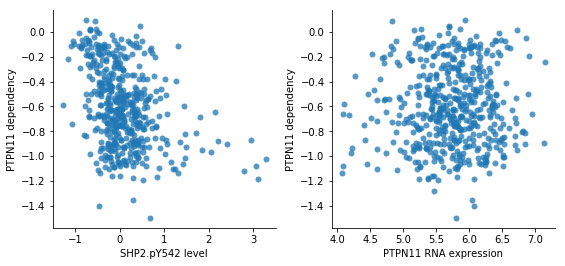

In [9]:
plt.figure(figsize=(9, 4))

ax = plt.subplot(121)
sns.scatterplot(rppa["SHP-2_pY542_Caution"],
                avana["PTPN11_5781"],
                alpha=0.75,
                linewidth=0
                )
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.xlabel("SHP2.pY542 level")
plt.ylabel("PTPN11 dependency")

ax = plt.subplot(122)
sns.scatterplot(ccle_genex["PTPN11_ENSG00000179295.11"],
                avana["PTPN11_5781"],
                alpha=0.75,
                linewidth=0
                )
plt.xlabel("PTPN11 RNA expression")
plt.ylabel("PTPN11 dependency")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.subplots_adjust(wspace=0.25)